##### FisherMatrixBNSpop.ipynb
### *simulated binary neutron star merger population with Fisher matrix parameter uncertainties*

this notebook samples from a population model for binary neutron star mergers and performs a Fisher matrix analysis with gwbench to calculate event signal-to-noise ratios and parameter uncertainties with respect to a given gravitational-wave detector network

##### philippe landry (pgjlandry@gmail.com) 07/2024

In [1]:
# import packages

import numpy as np
import pandas as pd
import math
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from tqdm import tqdm

import astropy.units as u
from astropy.coordinates import Distance
from astropy.cosmology import Planck15 as cosmo

from src.utils import *

/cvmfs/software.igwn.org/conda/envs/igwn-py39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/philippe.landry/gwbench/gwbench/wf_models/lal_bbh_np.py:17: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
# user input

# population model
RATE = 170. # local bns merger rate in Gpc^-3 yr^-1
MASS_MODEL = 'unif' # either uniform ('unif') or bimodal ('bimod') NS mass distribution
MMIN = 1.0 # minimum NS mass in population
MMAX = 2.3 # maximum NS mass in population (superseded by MTOV if larger than MTOV)
MPARAMS = [MMIN] #[1.34,0.07,1.80,0.21,0.65,MMIN] # mass distribution parameters, except for MMAX (automatically appended later)

# equation of state
EOS = 'slycr'
EOS_PATH = '/home/philippe.landry/nseos/eos/ref/macro-{0}.csv'.format(EOS) # EOS M-Lambda table

# observing scenario
TIME = 1./12. # observing time in yr
ZMIN = 0.01 # minimum redshift to model
ZMAX = 0.2 # maximum redshift to model
NETS = ['XG','HLV'] # list of detector networks to compute SNRs w.r.t, defined in dict below
NETS_DICT = {'XG': ['CE-40_H','CE-40_L','ET_V'], 'A+': ['A+_H','A+_L','V+_V'], 'HLV': ['aLIGO_H','aLIGO_L','aLIGO_V']}
NOISE = 0 # set zero for zero-noise injections, 1 for detector white noise

# fisher matrix
WF_MODEL = 'tf2_tidal' # waveform model
FMIN = 10. # Hz
FISHER_PARAMS = 'Mc eta DL chi1z chi2z iota lam_t' # parameters to take derivatives w.r.t.
CONV_COS = ('iota','dec') # convert to cosine
CONV_LOG = ('Mc','DL') # convert to log
USE_ROT = 0 # 0 to ignore rotation of Earth

# output
SEED = 0
OUTDIR = './{0}_BNS_{1}_v{2}/'.format(MASS_MODEL,EOS,SEED)

In [3]:
%%bash -s "$OUTDIR"
mkdir -p "$1"

In [4]:
# load population model and equation of state

# mass model
BNS_MASS_PDF = get_mass_model(MASS_MODEL)

# luminosity distance model
DL_PDF, DPARAMS = get_redshift_model(ZMIN,ZMAX)

# equation of state
eos_dat = np.genfromtxt(EOS_PATH,names=True,delimiter=',',dtype=None,encoding=None) # load m-Lambda table
Ms = eos_dat['M']
Lambdas = eos_dat['Lambda']

Mmax_pos = np.argmax(Ms) # truncate table at maximum NS mass
Ms = Ms[:Mmax_pos+1]
Mmax = Ms[-1]
Lambdas = Lambdas[:Mmax_pos+1]

Lambda_of_M = interp1d(Ms,Lambdas,kind='linear',bounds_error=True) # interpolate Lambda(M) function

In [5]:
# sample injected events from population model

np.random.seed(SEED)

# calculate size of simulated population
vt = 1e-9*cosmo.comoving_volume(ZMAX).value*TIME # sensitive volume-time product in Gpc^3*yr
npop = math.ceil(RATE*vt)
print('simulating population of {0} binary neutron star mergers'.format(npop))

# sample from mass model
m_grid = np.arange(max(MMIN,min(Ms)),min(MMAX,max(Ms)),0.01) # regular grid in NS masses

m1m2_grid = []
for m1 in m_grid:
    for m2 in m_grid:
        m1m2_grid += [(m1,m2)] # regular 2D grid in BNS masses

m1s_grid = np.array([m1 for m1,m2 in m1m2_grid]) # m1 points from the 2D grid
m2s_grid = np.array([m2 for m1,m2 in m1m2_grid]) # m2 points from the 2D grid
grid_pts = range(len(m1m2_grid)) # label each point in 2D grid

mparams = MPARAMS + [Mmax]
m1m2_wts = BNS_MASS_PDF(m1s_grid,m2s_grid,mparams) # weight each binary mass grid point by its probability according to the chosen BNS mass distribution, and truncate at the EOS's Mmax

sample_pts = np.random.choice(grid_pts,npop,replace=True,p=m1m2_wts/np.sum(m1m2_wts)) # draw samples from BNS mass distribution
m1s = m1s_grid[sample_pts]
m2s = m2s_grid[sample_pts]

# get corresponding tidal deformability samples, given equation of state
Lambda1s = np.array([Lambda_of_M(m1) for m1 in m1s]) # use interpolated M-Lambda relation
Lambda2s = np.array([Lambda_of_M(m2) for m2 in m2s])

# sample from luminosity distance model
dl_grid = np.arange(DPARAMS[0],DPARAMS[1],10.) # regular grid in luminosity distance
dl_wts = DL_PDF(dl_grid,DPARAMS)
dls = np.random.choice(dl_grid,npop,replace=True,p=dl_wts/np.sum(dl_wts))

# sample in inclination, sky location and other nuisance parameters
thetajn_grid = np.arange(0.,2.*np.pi,0.01)
thetajn_wts = [np.abs(np.sin(thetajn)) for thetajn in thetajn_grid]
thetajns = np.random.choice(thetajn_grid,npop,replace=True,p=thetajn_wts/np.sum(thetajn_wts))

dec_grid = np.arange(0.,2.*np.pi,0.01)
dec_wts = [np.abs(np.cos(dec)) for dec in dec_grid]
decs = np.random.choice(dec_grid,npop,replace=True,p=dec_wts/np.sum(dec_wts))

ras = np.random.uniform(0.,2.*np.pi,npop)
psis = np.random.uniform(0.,np.pi,npop)
phases = np.random.uniform(0.,2.*np.pi,npop)

simulating population of 12 binary neutron star mergers


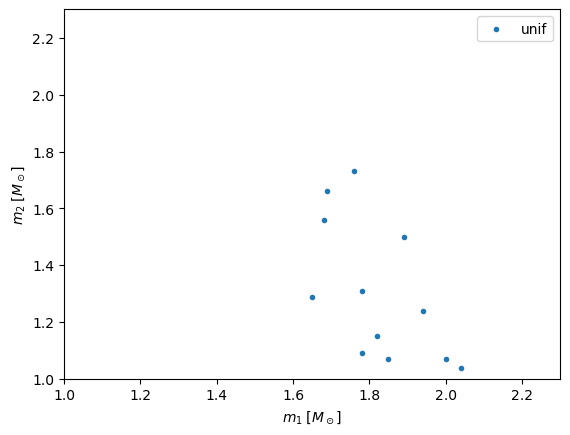

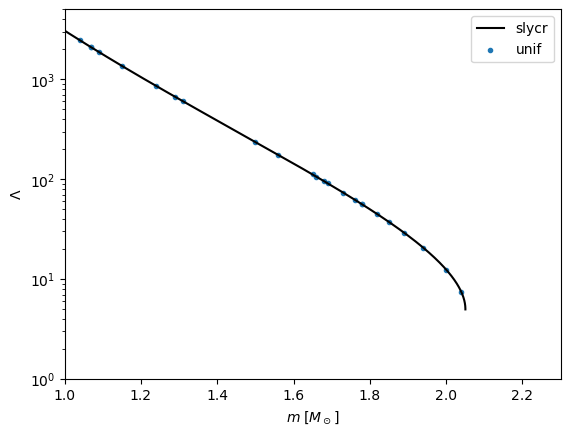

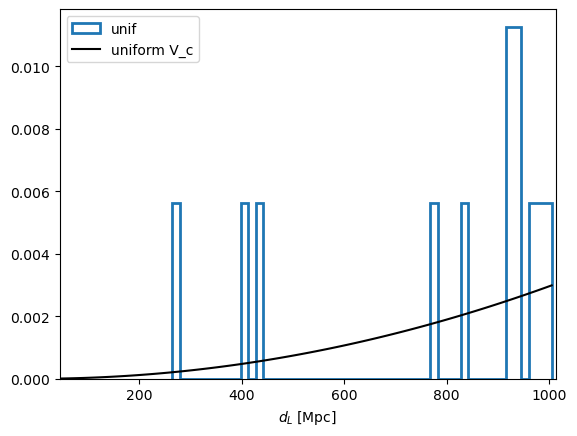

In [6]:
# save population to data frame and make some diagnostic plots

out_dict = {}
out_dict['m1'] = m1s
out_dict['m2'] = m2s
out_dict['mc'] = mchirp_from_mass1_mass2(m1s,m2s)
out_dict['eta'] = eta_from_mass1_mass2(m1s,m2s)
out_dict['Lambda1'] = Lambda1s
out_dict['Lambda2'] = Lambda2s
out_dict['Lambda_tilde'] = lambdatilde(Lambda1s,Lambda2s,m1s,m2s)
out_dict['deltaLambda_tilde'] = deltalambdatilde(Lambda1s,Lambda2s,m2s/m1s)
out_dict['dL'] = dls
out_dict['z'] = Distance(dls,unit=u.Mpc).compute_z(cosmology=cosmo)
out_dict['dec'] = decs
out_dict['thetajn'] = thetajns
out_dict['ra'] = ras
out_dict['psi'] = psis
out_dict['phase'] = phases
out_dat = pd.DataFrame(out_dict)

plt.figure()
plt.scatter(m1s,m2s,marker='.',label=MASS_MODEL) # scatter plot of BNS masses
plt.xlabel(r'$m_1\;[M_\odot]$')
plt.ylabel(r'$m_2\;[M_\odot]$')
plt.xlim(MMIN,MMAX)
plt.ylim(MMIN,MMAX)
plt.legend()
plt.show()

plt.figure()
plt.plot(Ms,Lambdas,c='k',label=EOS) # m1-Lambda1 and m2-Lambda2 samples overlaid on EOS's M-Lambda relation
plt.scatter(list(m1s)+list(m2s),list(Lambda1s)+list(Lambda2s),marker='.',label=MASS_MODEL)
plt.yscale('log')
plt.xlabel(r'$m\;[M_\odot]$')
plt.ylabel('$\Lambda$')
plt.xlim(MMIN,MMAX)
plt.ylim(1.,5000.)
plt.legend()
plt.show()

plt.figure()
plt.hist(dls,histtype='step',density=True,bins=50,lw=2,label=MASS_MODEL) # luminosity distance distribution compared to uniform-in-comoving-volume distribution
plt.plot(np.arange(DPARAMS[0],DPARAMS[1],10.),np.arange(DPARAMS[0],DPARAMS[1],10.)**2/np.trapz(np.arange(DPARAMS[0],DPARAMS[1],10.)**2,np.arange(DPARAMS[0],DPARAMS[1],10.)),c='k',label='uniform V_c')
plt.xlabel(r'$d_L\;[\mathrm{Mpc}]$')
plt.xlim(*DPARAMS)
plt.legend()
plt.show()

In [7]:
# calculate event signal to noise ratio and Fisher matrix errors based on its source parameters

for net_key in NETS:
    
    snrs, det_mcs, det_etas, det_Lts, dmcs, detas, dLts = [], [], [], [], [], [], []
    
    for i in tqdm(range(npop)):
        
        inj_params = out_dat.iloc[i]

        snr, dmc, deta, dLt = get_snrs(net_key,NETS_DICT,WF_MODEL,FMIN,FISHER_PARAMS,CONV_COS,CONV_LOG,USE_ROT,inj_params)

        snrs += [snr]

        det_mcs += [np.abs(inj_params['mc']+NOISE*np.random.normal(0.,dmc))]
        det_Lts += [np.abs(inj_params['Lambda_tilde']+NOISE*np.random.normal(0.,dLt))]
        
        eta_det = np.abs(inj_params['eta']+NOISE*np.random.normal(0.,deta))
        if eta_det >= 0.25: eta_det = 0.24999+(0.25-eta_det)
        det_etas += [eta_det]
        
        dmcs += [dmc]
        detas += [deta]
        dLts += [dLt]
    
    # save fisher matrix errors to data frame
    out_dat['snr'+'_{0}'.format(net_key)] =  snrs

    out_dat['mc'+'_{0}'.format(net_key)] =  det_mcs
    out_dat['eta'+'_{0}'.format(net_key)] =  det_etas
    out_dat['Lt'+'_{0}'.format(net_key)] =  det_Lts

    out_dat['dmc'+'_{0}'.format(net_key)] =  dmcs
    out_dat['deta'+'_{0}'.format(net_key)] =  detas
    out_dat['dLt'+'_{0}'.format(net_key)] =  dLts

100%|██████████| 12/12 [03:16<00:00, 16.37s/it]


In [8]:
# output data frame as csv

out_dat.to_csv(OUTDIR+'{0}_BNS_{1}.csv'.format(MASS_MODEL,EOS),index=False,float_format='%.4e')

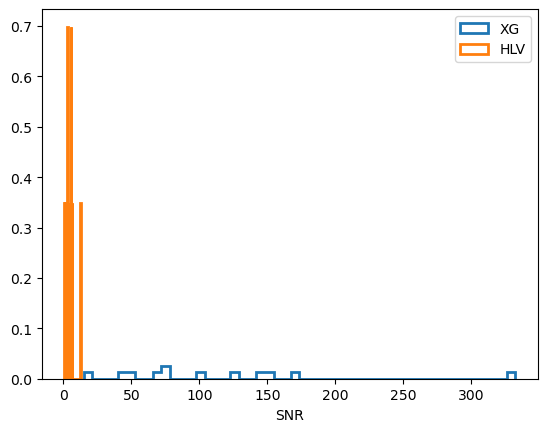

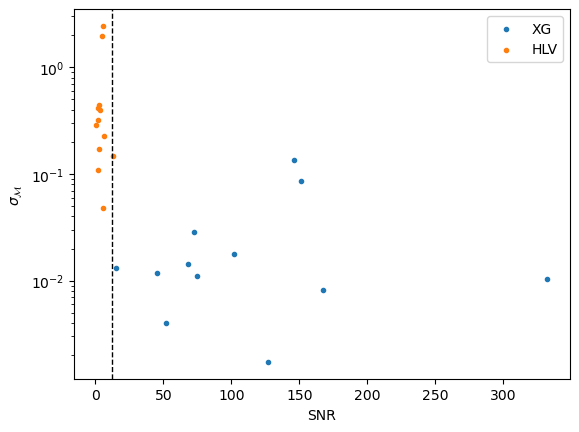

In [9]:
# make some diagnostic plots

plt.figure() # snr histogram
try: plt.hist(out_dat['snr_XG'],histtype='step',density=True,bins=50,lw=2,label='XG')
except: pass
try: plt.hist(out_dat['snr_A+'],histtype='step',density=True,bins=50,lw=2,label='A+')
except: pass
try: plt.hist(out_dat['snr_HLV'],histtype='step',density=True,bins=50,lw=2,label='HLV')
except: pass
plt.xlabel(r'SNR')
plt.legend()
plt.show()

plt.figure() # source-frame chirp mass error (dominated by z error at cosmological distances) vs snr
try: plt.scatter(out_dat['snr_XG'],out_dat['dmc_XG']/out_dat['mc_XG'],label='XG',marker='.')
except: pass
try: plt.scatter(out_dat['snr_A+'],out_dat['dmc_A+']/out_dat['mc_A+'],label='A+',marker='.')
except: pass
try: plt.scatter(out_dat['snr_HLV'],out_dat['dmc_HLV']/out_dat['mc_HLV'],label='HLV',marker='.')
except: pass
plt.axvline(12.,c='k',lw=1,ls='--')
plt.yscale('log')
plt.xlabel(r'SNR')
plt.ylabel(r'$\sigma_{\mathcal{M}}$')
plt.legend()
plt.show()